In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import operator
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline    

# data exploration - character_list.csv

In [2]:
# remove first 3 rows 
cl = pd.read_csv("../dev_data/character_list.csv", usecols = ['キャラマスタ名', 'シート内キャラID', 'レベル'])
cl.head()

,キャラマスタ名,シート内キャラID,レベル
0,アンパンマン,KC0002,SS
1,ウルトラマン,KC0003,SS
2,おかあさんといっしょ,KC0004,SS
3,きかんしゃトーマス,KC0005,SS
4,くまのプーさん,KC0006,SS


In [3]:
cl.columns

Index(['キャラマスタ名', 'シート内キャラID', 'レベル'], dtype='object')

In [4]:
cl['レベル'].unique()

array(['SS', '除外', 'A', 'B'], dtype=object)

In [5]:
# should be the same number
for col in ['キャラマスタ名', 'シート内キャラID', 'レベル']:
    print(f"nb of data in {col} is {cl[col].notnull().sum()}")

nb of data in キャラマスタ名 is 405
nb of data in シート内キャラID is 405
nb of data in レベル is 405


In [6]:
cl['レベル'].value_counts()

除外    271
B      55
A      44
SS     35
Name: レベル, dtype: int64

# data exploration - kids_characters_SIDs.csv

In [7]:
# remebmer to remove the first line 
df = pd.read_csv("../dev_data/kids_characters_SIDs.csv", usecols=['作品公開コード', '作品名', 'キャラクター名', 'シート内キャラID', 'キャラレベル'])
df.head()

,作品公開コード,作品名,キャラクター名,シート内キャラID,キャラレベル
0,SID0002134,愛少女ポリアンナ物語,NaN,NaN,NaN
1,SID0002135,愛の若草物語,NaN,NaN,NaN
2,SID0002136,藍より青し,NaN,NaN,NaN
3,SID0002137,藍より青し～縁～,NaN,NaN,NaN
4,SID0002138,AURA ～魔竜院光牙最後の闘い～,NaN,NaN,NaN


In [8]:
# numbers should be the same
for col in ['作品公開コード', '作品名', 'キャラクター名', 'シート内キャラID', 'キャラレベル']: 
    print(f"nb of data in {col} is {df[col].notnull().sum()}")

nb of data in 作品公開コード is 9002
nb of data in 作品名 is 9002
nb of data in キャラクター名 is 1707
nb of data in シート内キャラID is 1694
nb of data in キャラレベル is 1694


In [9]:
df[(df['キャラクター名'].notnull() & df['シート内キャラID'].isnull())]

,作品公開コード,作品名,キャラクター名,シート内キャラID,キャラレベル
4524,SID0012700,AKB0048,AKB48,NaN,NaN
4525,SID0012701,AKB0048 next stage,AKB48,NaN,NaN
4617,SID0012808,SDガンダム 嵐を呼ぶ学園祭,SDガンダム,NaN,NaN
4618,SID0012809,SDガンダム 戦国伝 暴終空城の章,SDガンダム,NaN,NaN
4619,SID0014067,SDガンダムフォース,SDガンダム,NaN,NaN
4620,SID0056091,SDガンダムワールド ヒーローズ,SDガンダム,NaN,NaN
4621,SID0058894,SDガンダムワールド 三国創傑伝,SDガンダム,NaN,NaN
5116,SID0002606,サイボーグ009 超銀河伝説,サイボーグ9,NaN,NaN
5117,SID0003011,サイボーグ009 THE CYBORG SOLDIER,サイボーグ9,NaN,NaN
5233,SID0042358,おはよう！スパンク,スパンク,NaN,NaN


In [10]:
# it seems the characters with name but without ID are not in character_list
for c_name in df[(df['キャラクター名'].notnull() & df['シート内キャラID'].isnull())]['キャラクター名'].unique():
    print(cl[cl['キャラマスタ名'] == c_name])

Empty DataFrame
Columns: [キャラマスタ名, シート内キャラID, レベル]
Index: []
Empty DataFrame
Columns: [キャラマスタ名, シート内キャラID, レベル]
Index: []
Empty DataFrame
Columns: [キャラマスタ名, シート内キャラID, レベル]
Index: []
Empty DataFrame
Columns: [キャラマスタ名, シート内キャラID, レベル]
Index: []
Empty DataFrame
Columns: [キャラマスタ名, シート内キャラID, レベル]
Index: []
Empty DataFrame
Columns: [キャラマスタ名, シート内キャラID, レベル]
Index: []


In [11]:
# remove '除外' character
pdf = df.dropna(axis=0, how='any', subset=['キャラレベル'], inplace=False)
pdf = pdf[pdf['キャラレベル'] != '除外']
pdf.head()

,作品公開コード,作品名,キャラクター名,シート内キャラID,キャラレベル
4527,SID0003144,BLEACH,BLEACH,KC0215,B
4528,SID0029042,BORUTO-ボルト- NARUTO NEXT GENERATIONS,BORUTO,KC0055,A
4529,SID0053510,BORUTO -NARUTO THE MOVIE-,BORUTO,KC0055,A
4532,SID0025580,DAYS,DAYS,KC0356,B
4533,SID0054283,DAYS 東院学園編,DAYS,KC0356,B


In [12]:
# numbers of SID with キャラレベル != '除外'
len(pdf)

1385

# make character -> SID mapping table

In [13]:
# df.groupby('キャラクター名',as_index=False).aggregate(lambda df: "|".join(df.unique().tolist()))
gdf = pdf.groupby('キャラクター名',as_index=False).aggregate(lambda pdf: pdf.unique().tolist())
gdf.head()

,キャラクター名,作品公開コード,作品名,シート内キャラID,キャラレベル
0,BLEACH,[SID0003144],[BLEACH],[KC0215],[B]
1,BORUTO,"[SID0029042, SID0053510]","[BORUTO-ボルト- NARUTO NEXT GENERATIONS, BORUTO -...",[KC0055],[A]
2,DAYS,"[SID0025580, SID0054283]","[DAYS, DAYS 東院学園編]",[KC0356],[B]
3,DRAGON QUEST ダイの大冒険,"[SID0027069, SID0044873, SID0050918, SID005451...","[ドラゴンクエスト《勇者アベル伝説》, ドラゴンクエスト ダイの大冒険(1991), ドラゴ...",[KC0199],[B]
4,EDENS ZERO,[SID0056092],[EDENS ZERO],[KC0073],[A]


In [14]:
character_sids_dict = {k:v for k, v in zip(gdf['キャラクター名'], gdf['作品公開コード'])}

In [14]:
with open("kids_character_mapping.pkl", "wb") as fp:   #Pickling
    pickle.dump(character_sids_dict, fp)

In [15]:
cnt_dict = {}
for k, v in zip(gdf['キャラクター名'], gdf['作品公開コード']):
    cnt_dict[len(v)] = cnt_dict.setdefault(len(v), []) + [k]

In [16]:
{k:v for k, v in sorted(cnt_dict.items(), key=operator.itemgetter(0), reverse=False)}

{1: ['BLEACH',
  'EDENS ZERO',
  'PUI PUI モルカー',
  'iiiあいすくりん',
  'あひるの空',
  'おしりかじり虫',
  'のりものまん モービルランドのカークン',
  'ふしぎ駄菓子屋 銭天堂',
  'カピバラさん',
  'キテレツ',
  'コラショ',
  'スヌーピー',
  'スパイダーマン',
  'タンタン',
  'バッドばつ丸',
  'パウ・パトロール',
  'フィン＆ジェイク',
  'ブラッククローバー',
  'ペッパピッグ＆パジャマスク-',
  'ペネロペ',
  'マジカパーティー',
  'ミュークルドリーミー',
  'レイトン教授',
  '宇宙なんちゃら こてつくん',
  '斉木楠雄のΨ難'],
 2: ['BORUTO',
  'DAYS',
  'SONIC',
  'おじゃる丸',
  'おとうさんといっしょ',
  'かいじゅうステップ\u3000ワンダバダ',
  'ちびまる子ちゃん',
  'ぼのぼの',
  'ウサハナ',
  'カンフー・パンダ',
  'シナモン',
  'シャーマンキング',
  'スポンジ・ボブ',
  'ティニー',
  'ドゲンジャーズ',
  'モンスターズインク',
  'ワールドトリガー',
  '炎炎ノ消防隊',
  'Ｄｒ．ＳＴＯＮＥ'],
 3: ['HUNTER×HUNTER',
  'おさるのジョージ',
  'おしりたんてい',
  'はなかっぱ',
  'アナと雪の女王',
  'チャギントン',
  'ムーミン',
  'リトルツインスターズ(キキ＆ララ)',
  'ルルロロ'],
 4: ['カードキャプターさくら',
  'キューティーハニー',
  'タマ＆フレンズ',
  'ダイヤのA',
  'デュエル･マスターズ',
  'パズドラ',
  'ミッフィー',
  'ミニオンズ',
  '少年アシベ ',
  '幽☆遊☆白書',
  '暗殺教室'],
 5: ['FAIRY TAIL',
  'WASIMO',
  'あたしンち',
  'みいつけた！',
  'るろうに剣心－明治剣客浪漫譚－',
  'コボちゃん',
  'トイストーリー',
  'マイメロディ',
  'ミッキーマウ

## draw figs

Text(0, 0.5, 'nb of characters')

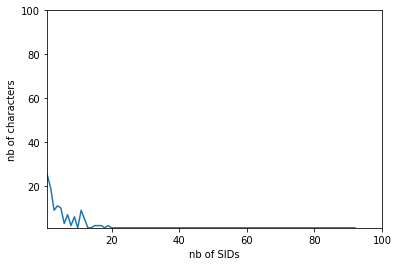

In [17]:
vc = pdf['キャラクター名'].value_counts().value_counts()   
# sort by index and plot
vc.sort_index().plot(xlim=(1,100),ylim=(1,100))
plt.xlabel('nb of SIDs')  # set text for x-axis
plt.ylabel('nb of characters')  # set text for y-axis

# make fake training data - 200 random

In [18]:
import random

In [18]:
sid_list = list(pdf['作品公開コード'])
sid_list[:3]

['SID0003144', 'SID0029042', 'SID0053510']

In [32]:
# fans of NARUTO, fans of アンパン, fans of 妖怪ウォッチ, fans of kitty

# userid,item,rating
with open("fake_kids_user_sakuhin_score_200.csv", "w") as w:
    w.write("userid,item,rating\n")
    for sid_name in ['アンパンマン', '妖怪ウォッチ', 'NARUTO', 'ハローキティ']:
        for sid in character_sids_dict[sid_name][:7]:
            w.write(f'fan_{sid_name},{sid},1\n')

# fan_naruto, fan_anpan, fan_watch,  fan_kitty

In [33]:
# 200 users, random pick 7 作品 from sid_list
with open("fake_kids_user_sakuhin_score_200.csv", "a") as a:
    for i in range(200):  # 200 fake users
        for j in range(7):  # 7 fake data
            a.write(f"fake_user_{i},{sid_list[random.randint(0, len(sid_list)-1)]},1\n")

# make fake training data - fan + real data

In [19]:
# try different weights
with open("user_sakuhin_score.csv", "a") as w:
    for sid_name in ['アンパンマン', '妖怪ウォッチ', 'NARUTO', 'ハローキティ', 'ドラゴンボール']:
        for sid in character_sids_dict[sid_name][:7]:
            w.write(f'fan_{sid_name},{sid},3\n')

# fan_naruto, fan_anpan, fan_watch,  fan_kitty

# make fake training data - fan + real data kids only

In [38]:
kids_sid_set = set(pdf['作品公開コード'])

In [41]:
with open("fake_kids_only_user_sakuhin_score.csv", "a") as w:
    w.write("userid,item,rating\n")
    for line in e_reading("fake_kids_user_sakuhin_score.csv", "r"):
        arr = line.rstrip().split(',')
        if arr[1] in kids_sid_set:
            w.write(line)

In [37]:
def e_reading(input_path, with_header=True, header_format=None):
    """
    yield one line at once til go through entire file,

    & check the header_format
    """
    with open(input_path, 'r') as r:
        if with_header:
            header = r.readline().rstrip()
            if header_format:
                assert header == header_format, f"Header Format is WRONG"
        while True:
            line = r.readline()
            if line:
                yield line
            else:
                break